In [9]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['font.sans-serif']='SimHei' #图表显示中文

import yfinance as yf
yf.pdr_override() #需要调用这个函数

# 1、获取股票数据
#上海的股票代码+.SS;深圳的股票代码+.SZ :
stock = web.get_data_yahoo("601318.SS", start="2022-01-01", end="2023-07-17")
# 保存到csv中
pd.DataFrame(data=stock).to_csv('./stock.csv')


# 2、获取csv中的数据
features = pd.read_csv('stock.csv')
features = features.drop('Adj Close',axis=1)
features.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
0,2022-01-04,50.400002,51.060001,50.099998,51.000000,63583763
1,2022-01-05,51.110001,52.400002,50.970001,52.070000,118124669
2,2022-01-06,51.990002,52.020000,51.220001,51.299999,66165825
3,2022-01-07,51.490002,53.330002,51.450001,52.939999,123075974
4,2022-01-10,52.990002,53.560001,52.500000,53.080002,76113442


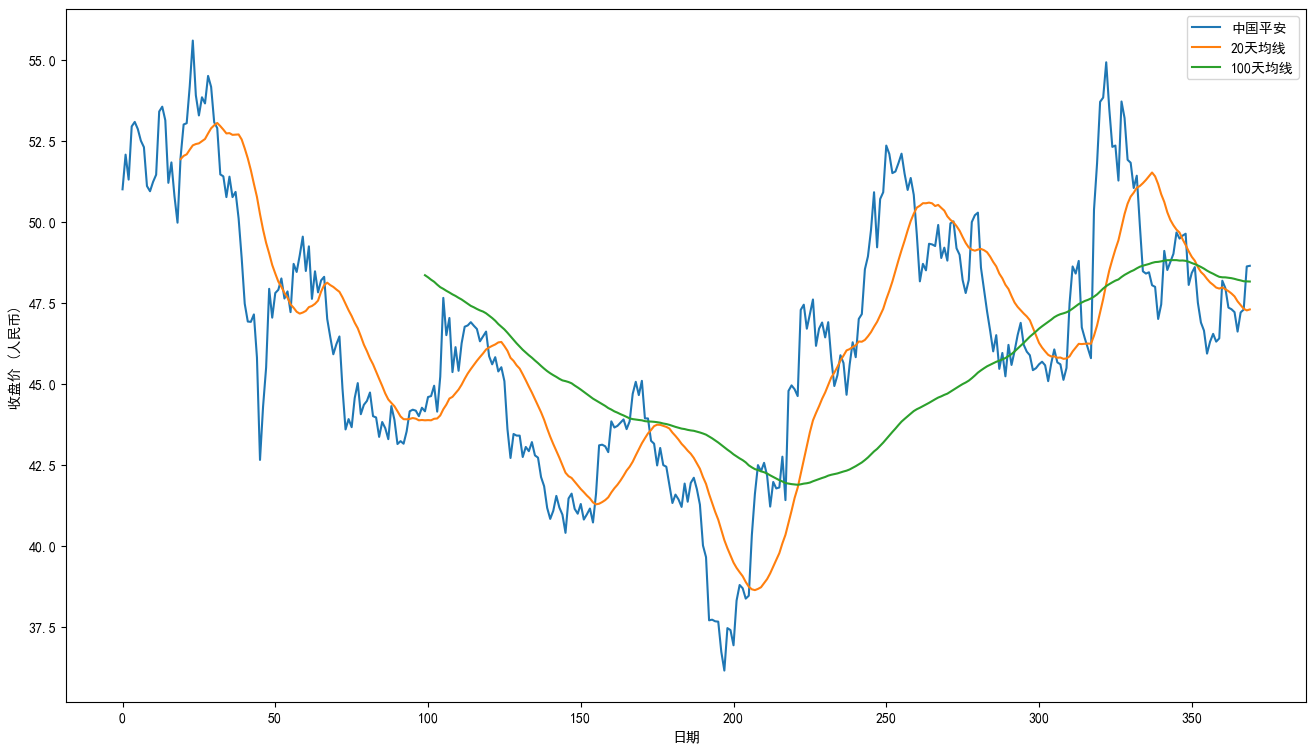

In [10]:
# 3、绘图看看收盘价数据情况
close=features["Close"]
# 计算20天和100天移动平均线：
short_rolling_close = close.rolling(window=20).mean()
long_rolling_close = close.rolling(window=100).mean()
# 绘制
fig, ax = plt.subplots(figsize=(16,9))   #画面大小，可以修改
ax.plot(close.index, close, label='中国平安')   #以收盘价为索引值绘图
ax.plot(short_rolling_close.index, short_rolling_close, label='20天均线')
ax.plot(long_rolling_close.index, long_rolling_close, label='100天均线')
#x轴、y轴及图例：
ax.set_xlabel('日期')
ax.set_ylabel('收盘价 (人民币)')
ax.legend()      #图例
plt.show()      #绘图

In [11]:
# 4、取出label值
labels = features['Close']
time = features['Date']
features = features.drop('Date',axis=1)
features.head()

,Open,High,Low,Close,Volume
0,50.400002,51.060001,50.099998,51.000000,63583763
1,51.110001,52.400002,50.970001,52.070000,118124669
2,51.990002,52.020000,51.220001,51.299999,66165825
3,51.490002,53.330002,51.450001,52.939999,123075974
4,52.990002,53.560001,52.500000,53.080002,76113442


In [12]:
# 5、数据预处理
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)
input_features

array([[ 1.02971116,  1.04210508,  1.10475153,  1.1829114 ,  0.20747217],
       [ 1.21357284,  1.38427888,  1.33595335,  1.46007797,  2.0171465 ],
       [ 1.44145831,  1.28724425,  1.40239045,  1.26062148,  0.29314532],
       ...,
       [ 0.20103751,  0.24795538,  0.30219229,  0.22189456, -0.72636326],
       [ 0.33569707,  0.45223802,  0.45366879,  0.5664096 ,  0.25037617],
       [ 0.67234546,  0.53905827,  0.65563712,  0.57159041, -0.6866633 ]])

In [13]:
# 6、定义序列，[下标1-20天预测第21天的收盘价]
from collections import deque

x = []
y = []

seq_len = 20
deq = deque(maxlen=seq_len)
for i in input_features:
    deq.append(list(i))
    if len(deq) == seq_len:
        x.append(list(deq))

x = x[:-1] # 取少一个序列，因为最后个序列没有答案
y = features['Close'].values[seq_len: ] #从第二十一天开始（下标为20）
time = time.values[seq_len: ] #从第二十一天开始（下标为20）

x, y, time = np.array(x), np.array(y), np.array(time)
print(x.shape)
print(y.shape)
print(time.shape)

(350, 20, 5)
(350,)
(350,)
53.0
2022-02-08


In [15]:
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.optimizers import Adam

# 7、搭建模型
model = tf.keras.Sequential()
model.add(layers.GRU(8,input_shape=(20,5), activation='relu', return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.GRU(16, activation='relu', return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.GRU(32, activation='relu', return_sequences=False,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dense(16,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 8)             360       
                                                                 
 gru_1 (GRU)                 (None, 20, 16)            1248      
                                                                 
 gru_2 (GRU)                 (None, 32)                4800      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,953
Trainable params: 6,953
Non-trainable params: 0
_________________________________________________________________


In [38]:
# 优化器和损失函数
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.MeanAbsoluteError(), # 标签和预测之间绝对差异的平均
              metrics = tf.keras.losses.MeanSquaredLogarithmicError()) # 计算标签和预测
# 开始训练
model.fit(x,y,validation_split=0.25,epochs=200,batch_size=128)

Epoch 1/200
3/3 [==============================] - 5s 300ms/step - loss: 3.7345 - mean_squared_logarithmic_error: 0.0072 - val_loss: 3.8460 - val_mean_squared_logarithmic_error: 0.0072
Epoch 2/200
3/3 [==============================] - 0s 31ms/step - loss: 3.4643 - mean_squared_logarithmic_error: 0.0071 - val_loss: 3.7766 - val_mean_squared_logarithmic_error: 0.0066
Epoch 3/200
3/3 [==============================] - 0s 29ms/step - loss: 2.3330 - mean_squared_logarithmic_error: 0.0026 - val_loss: 3.7443 - val_mean_squared_logarithmic_error: 0.0078
Epoch 4/200
3/3 [==============================] - 0s 31ms/step - loss: 3.6507 - mean_squared_logarithmic_error: 0.0065 - val_loss: 2.8698 - val_mean_squared_logarithmic_error: 0.0045
Epoch 5/200
3/3 [==============================] - 0s 27ms/step - loss: 2.0686 - mean_squared_logarithmic_error: 0.0039 - val_loss: 4.0146 - val_mean_squared_logarithmic_error: 0.0075
Epoch 6/200
3/3 [==============================] - 0s 26ms/step - loss: 2.8811 

3/3 [==============================] - 0s 29ms/step - loss: 1.8022 - mean_squared_logarithmic_error: 0.0020 - val_loss: 2.1241 - val_mean_squared_logarithmic_error: 0.0023
Epoch 46/200
3/3 [==============================] - 0s 28ms/step - loss: 1.4389 - mean_squared_logarithmic_error: 9.3198e-04 - val_loss: 2.3071 - val_mean_squared_logarithmic_error: 0.0027
Epoch 47/200
3/3 [==============================] - 0s 32ms/step - loss: 2.0097 - mean_squared_logarithmic_error: 0.0016 - val_loss: 1.7770 - val_mean_squared_logarithmic_error: 0.0015
Epoch 48/200
3/3 [==============================] - 0s 33ms/step - loss: 1.3971 - mean_squared_logarithmic_error: 0.0011 - val_loss: 2.2883 - val_mean_squared_logarithmic_error: 0.0025
Epoch 49/200
3/3 [==============================] - 0s 33ms/step - loss: 1.7904 - mean_squared_logarithmic_error: 0.0017 - val_loss: 1.7382 - val_mean_squared_logarithmic_error: 0.0015
Epoch 50/200
3/3 [==============================] - 0s 30ms/step - loss: 1.3250 - me

Epoch 89/200
3/3 [==============================] - 0s 28ms/step - loss: 1.1054 - mean_squared_logarithmic_error: 5.3850e-04 - val_loss: 1.5175 - val_mean_squared_logarithmic_error: 0.0011
Epoch 90/200
3/3 [==============================] - 0s 30ms/step - loss: 1.1341 - mean_squared_logarithmic_error: 5.6968e-04 - val_loss: 1.4961 - val_mean_squared_logarithmic_error: 0.0011
Epoch 91/200
3/3 [==============================] - 0s 28ms/step - loss: 1.1284 - mean_squared_logarithmic_error: 5.7784e-04 - val_loss: 1.5143 - val_mean_squared_logarithmic_error: 0.0011
Epoch 92/200
3/3 [==============================] - 0s 26ms/step - loss: 1.1048 - mean_squared_logarithmic_error: 5.8283e-04 - val_loss: 1.5391 - val_mean_squared_logarithmic_error: 0.0012
Epoch 93/200
3/3 [==============================] - 0s 29ms/step - loss: 1.0934 - mean_squared_logarithmic_error: 5.8604e-04 - val_loss: 1.4980 - val_mean_squared_logarithmic_error: 0.0011
Epoch 94/200
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 27ms/step - loss: 1.0163 - mean_squared_logarithmic_error: 4.9516e-04 - val_loss: 1.4371 - val_mean_squared_logarithmic_error: 9.8107e-04
Epoch 133/200
3/3 [==============================] - 0s 27ms/step - loss: 1.0106 - mean_squared_logarithmic_error: 5.0854e-04 - val_loss: 1.4916 - val_mean_squared_logarithmic_error: 0.0011
Epoch 134/200
3/3 [==============================] - 0s 27ms/step - loss: 1.0250 - mean_squared_logarithmic_error: 5.4372e-04 - val_loss: 1.4661 - val_mean_squared_logarithmic_error: 0.0010
Epoch 135/200
3/3 [==============================] - 0s 27ms/step - loss: 1.1368 - mean_squared_logarithmic_error: 6.7916e-04 - val_loss: 1.4759 - val_mean_squared_logarithmic_error: 0.0011
Epoch 136/200
3/3 [==============================] - 0s 27ms/step - loss: 1.0265 - mean_squared_logarithmic_error: 5.4270e-04 - val_loss: 1.6502 - val_mean_squared_logarithmic_error: 0.0013
Epoch 137/200
3/3 [==============================] - 0s 27ms

3/3 [==============================] - 0s 27ms/step - loss: 0.9790 - mean_squared_logarithmic_error: 4.1568e-04 - val_loss: 1.8001 - val_mean_squared_logarithmic_error: 0.0016
Epoch 176/200
3/3 [==============================] - 0s 30ms/step - loss: 1.1427 - mean_squared_logarithmic_error: 4.9854e-04 - val_loss: 1.6002 - val_mean_squared_logarithmic_error: 0.0012
Epoch 177/200
3/3 [==============================] - 0s 28ms/step - loss: 1.1418 - mean_squared_logarithmic_error: 6.0143e-04 - val_loss: 1.5498 - val_mean_squared_logarithmic_error: 0.0012
Epoch 178/200
3/3 [==============================] - 0s 32ms/step - loss: 1.0096 - mean_squared_logarithmic_error: 5.1108e-04 - val_loss: 1.5053 - val_mean_squared_logarithmic_error: 0.0011
Epoch 179/200
3/3 [==============================] - 0s 31ms/step - loss: 1.0435 - mean_squared_logarithmic_error: 7.6711e-04 - val_loss: 1.4696 - val_mean_squared_logarithmic_error: 0.0010
Epoch 180/200
3/3 [==============================] - 0s 31ms/ste

11/11 [==============================] - 1s 5ms/step


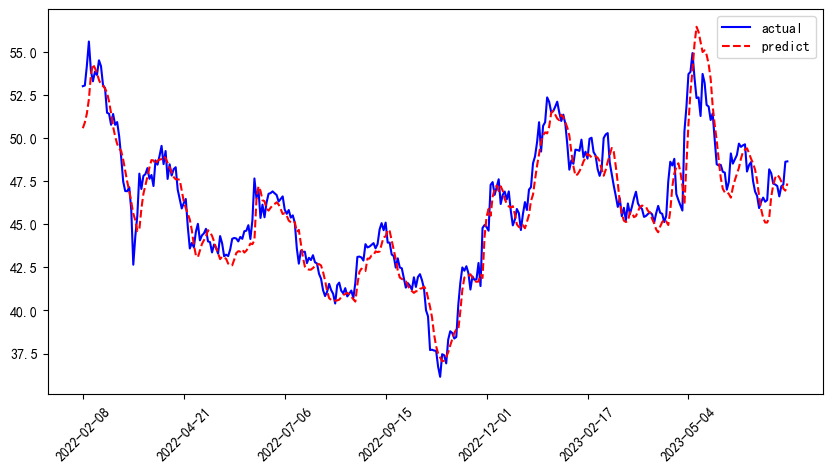

In [39]:
# 预测
y_pred = model.predict(x)
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(time,y,'b-',label='actual')
# 预测值，红色散点
axes.plot(time,y_pred,'r--',label='predict')
axes.set_xticks(time[::50])
axes.set_xticklabels(time[::50],rotation=45)
 
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt

#回归评价指标
# calculate MSE 均方误差
mse=mean_squared_error(y,y_pred)
# calculate RMSE 均方根误差
rmse = sqrt(mean_squared_error(y, y_pred))
#calculate MAE 平均绝对误差
mae=mean_absolute_error(y,y_pred)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 1.360957
均方根误差: 1.166600
平均绝对误差: 0.882024
